<a href="https://colab.research.google.com/github/Romulol-B/Image_Matching_2025/blob/main/loftr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!pip install gdown

  Cloning https://github.com/giuliano-oliveira/gdown_folder.git to /tmp/pip-req-build-l8v4p3cm
  Running command git clone --filter=blob:none --quiet https://github.com/giuliano-oliveira/gdown_folder.git /tmp/pip-req-build-l8v4p3cm
  Resolved https://github.com/giuliano-oliveira/gdown_folder.git to commit a3fb6565e56b8294994f1faa2534a5a2a31a7b94
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install --upgrade gdown

import gdown
# a file
url = 'https://drive.google.com/uc?id=1Hm6HFfeckASmlHUA0cCDgQIoQc5Vrm7S'
output = "kaggle.json"
gdown.download(url, quiet=True,output=output)

'kaggle.json'

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
import shutil
from PIL import Image
import torchvision
import random
from torchvision import transforms
import math

In [ ]:
!kaggle competitions download -c image-matching-challenge-2025
!unzip -q image-matching-challenge-2025

100% 4.83G/4.84G [01:52<00:00, 113MB/s] 
100% 4.84G/4.84G [01:52<00:00, 46.0MB/s]


In [ ]:
brightness=(0.98, 1.02)
gamma=(0.5, 1.1)
gaussian_std=(0,0.02)
resolution = (256 , 256)

In [ ]:
def delete_np(y,indice):
  y = np.concatenate((y[:indice],y[indice+1:]))
  return y

In [ ]:
def data_augmentation(img, brightness=(0.98, 1.02), gamma=(0.5, 1.1), gaussian_std=(0,0.02)):
  img = (img + 1) / 2  # Map from [-1, 1] to [0, 1] if normalized

  gamma_val = random.uniform(gamma[0], gamma[1])
  img = transforms.functional.adjust_gamma(img, gamma_val)

  brightness_val = random.uniform(brightness[0], brightness[1])
  img = transforms.functional.adjust_brightness(img, brightness_val)
  # Gaussian noise (if needed)
  noise = torch.randn_like(img) * random.uniform(gaussian_std[0],gaussian_std[1])
  img = img + noise

  # Clamp and re-normalize to [-1, 1]
  img = torch.clamp(img, 0, 1)  # First clamp to [0, 1]
  img = img * 2 - 1  # Map back to [-1, 1]

  return img

In [ ]:
transform = transforms.Compose([
    transforms.Resize(resolution),
    transforms.ToTensor(),  # [0, 1]
    transforms.Normalize(mean=[0.5], std=[0.5]),  # [-1, 1]
    transforms.Grayscale(),
    transforms.RandomApply(
        [transforms.Lambda(lambda x: data_augmentation(x))],
        p=0.5  # 50% chance to apply
    ),
])
kaggle_data = torchvision.datasets.ImageFolder('/content/train/',transform=transform)
data_loader = torch.utils.data.DataLoader(kaggle_data, batch_size=1)

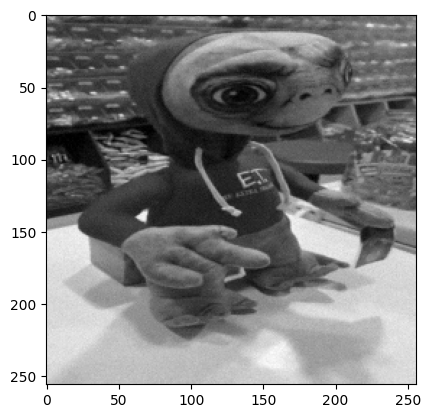

In [ ]:
img, label = kaggle_data[6]
plt.imshow(img.permute(1, 2, 0),cmap='grey')

loftr

In [ ]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

# Download pretrained weights
!mkdir weights
%cd weights/
!gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
%cd ..

fatal: destination path 'LoFTR' already exists and is not an empty directory.
mv: cannot move 'LoFTR/assets' to './assets': Directory not empty
mv: cannot move 'LoFTR/configs' to './configs': Directory not empty
mv: cannot move 'LoFTR/data' to './data': Directory not empty
mv: cannot move 'LoFTR/demo' to './demo': Directory not empty
mv: cannot move 'LoFTR/docs' to './docs': Directory not empty
mv: cannot move 'LoFTR/notebooks' to './notebooks': Directory not empty
mv: cannot move 'LoFTR/scripts' to './scripts': Directory not empty
mv: cannot move 'LoFTR/src' to './src': Directory not empty
mv: cannot move 'LoFTR/third_party' to './third_party': Directory not empty
mkdir: cannot create directory ‘weights’: File exists
/content/weights
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Can

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

In [ ]:
# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
image_type='outdoor'
if image_type == 'indoor':
  matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
elif image_type == 'outdoor':
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
else:
  raise ValueError("Wrong image_type is given.")
matcher = matcher.eval().cpu()

In [ ]:
def dual_matching(img0_raw ,img01_raw,confi=0.25):

  img0_raw = img0_raw.flatten(start_dim=0,end_dim=1)
  img01_raw = img01_raw.flatten(start_dim=0,end_dim=1)

  # colocando na resolucao 1,1,256,256
  img0 = img0_raw[None,None,:,:]
  assert img0.shape ==(1,1,resolution[0],resolution[1])
  img01 = img01_raw[None,None,:,:]
  assert img01.shape ==(1,1,resolution[0],resolution[1])

  batch = {'image0': img0, 'image1': img01}

  # Inference with LoFTR and get prediction
  with torch.no_grad():
      matcher(batch)
      mkpts0 = batch['mkpts0_f'].cpu().numpy()
      mkpts1  = batch['mkpts1_f'].cpu().numpy()
      mconf = batch['mconf'].cpu().numpy()
  i = 0
  for item in range(len(mkpts0)):
    if mconf[i] <confi:
      mkpts0= delete_np(mkpts0,i)
      mkpts1=delete_np(mkpts1,i)
      mconf=delete_np(mconf,i)
      i-=1
    i +=1
  angs= []
  for i in range(len(mconf)):
    angs.append(math.atan2((mkpts1[i]-mkpts0[i])[0].item(),(mkpts1[i]-mkpts0[i])[1].item()) )
  return mkpts0, mkpts1, mconf ,angs

In [ ]:
def draw_points(img0_raw, img01_raw, mkpts0, mkpts1,mconf):
  img0_raw = img0_raw.flatten(start_dim=0,end_dim=1)
  img01_raw = img01_raw.flatten(start_dim=0,end_dim=1)

  color = cm.jet(mconf, alpha=0.7)
  text = [
      'LoFTR',
      'Matches: {}'.format(len(mkpts0)),
  ]
  fig = make_matching_figure(img0_raw, img01_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)


  # A high-res PDF will also be downloaded automatically.
  #make_matching_figure(img0_raw, img01_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path="LoFTR-colab-demo.pdf")

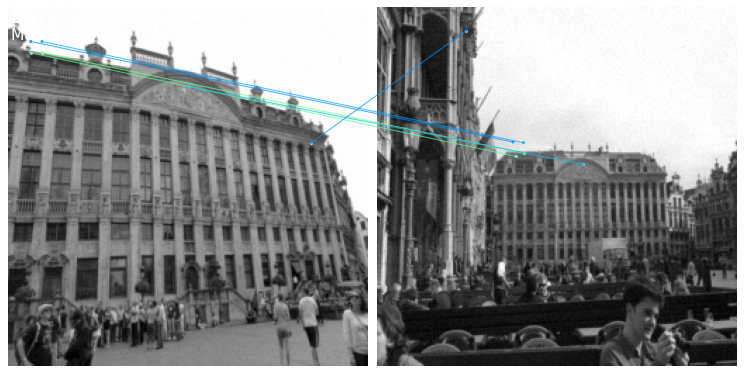

In [ ]:
img0 ,_ = kaggle_data[-601]
img01 ,_ = kaggle_data[-602]
p1, p2, conf, angs =dual_matching(img0,img01)
draw_points(img0,img01, p1, p2, conf)

In [ ]:
def conf_sum(z,exp =3):
  return sum(np.power(np.array(z),exp))


In [ ]:
def rotation_matcher(img0,img01,rotation_rate =45):
  img01_raw =img01
  highst_conf = 0
  angle_best = 0
  for i in range(int(360/rotation_rate)):

    img01=torchvision.transforms.functional.rotate(img01_raw,angle= i*rotation_rate)
    p1, p2, conf, angs = dual_matching(img0,img01)
    #draw_points(img0,img01, p1, p2, conf)
    conf_total = conf_sum(conf)

    if highst_conf < conf_total:
      highst_conf = conf_total
      angle_best = i*rotation_rate

  img01=torchvision.transforms.functional.rotate(img01_raw,angle=angle_best)
  p1, p2, conf, angs =dual_matching(img0,img01)

  #draw_points(img0,img01, p1, p2, conf)
  return p1, p2, conf,angle_best ,highst_conf

In [ ]:
p1, p2, conf,angle_best ,highst_conf= rotation_matcher(img0,img01)

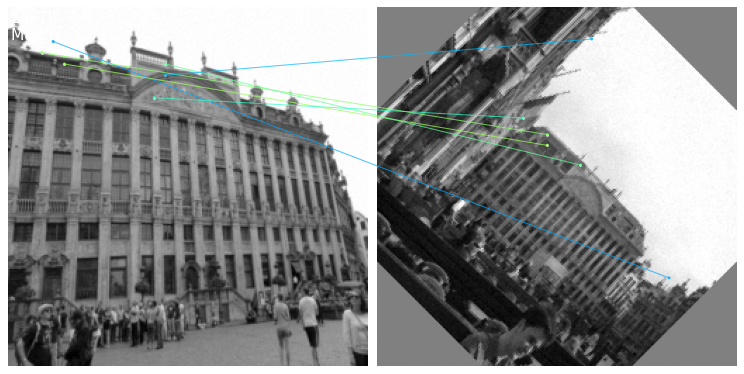

In [ ]:
ang_01 = torchvision.transforms.functional.rotate(img01,angle_best)
p1, p2, conf, angs =dual_matching(img0,ang_01)
draw_points(img0,ang_01,p1,p2,conf)

In [ ]:
angle_best

315

In [ ]:
conf_sum(conf)

np.float32(0.5203515)

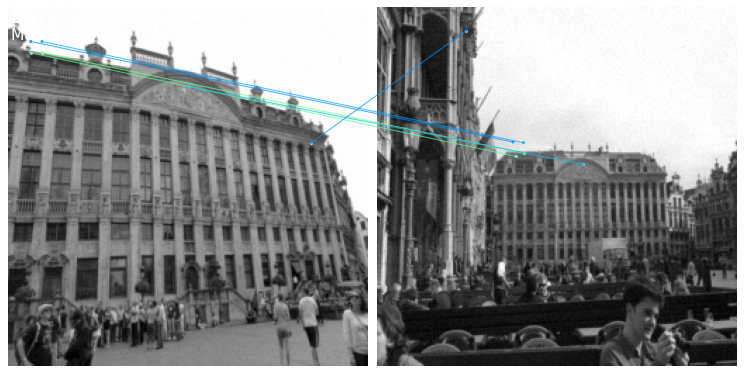

In [ ]:
p1, p2, conf, angs =dual_matching(img0,img01)
draw_points(img0,img01,p1,p2,conf)

In [ ]:
conf_sum(conf)

np.float32(0.30230454)

In [ ]:
"""for img,label in kaggle_data:
  if label ==4:
    p1, p2, conf,ang,conf = rotation_matcher(stone,img)
    if ang != 0:
      img=torchvision.transforms.functional.rotate(img,angle=ang)
      p1, p2, conf,angs=dual_matching(stone,img)
      draw_points(stone,img,p1,p2,conf)"""

In [ ]:
"""draw_points(stone,img,p1,p2,conf)"""

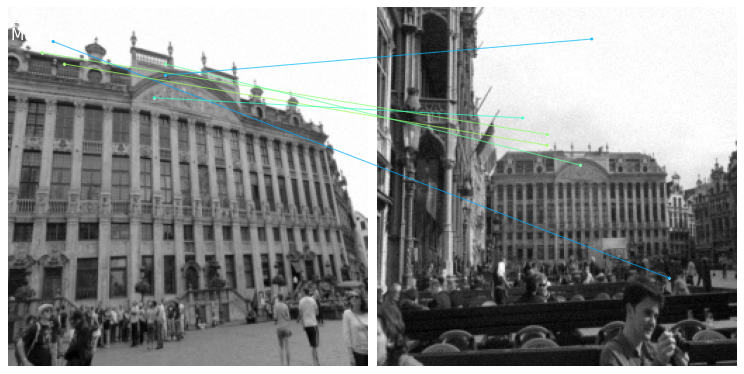

In [ ]:
draw_points(img0,img01,p1,p2,conf)